FLoor Plans

In [142]:
# -----------------------------------------------------------------------------
# Floor plan options for the assignment
# -----------------------------------------------------------------------------

import numpy as np

def load_floor_plan(name="baseline"):
    """
    Load a predefined floor plan.

    Available options:
      - "baseline"  : corridor + corner (recommended default)
      - "zigzag"    : narrow zig-zag corridor (oscillation test)
      - "deadend"   : dead-end with escape (local minimum trap)
      - "symmetric" : symmetric obstacle trap (pathological case)

    Returns:
      walls : list of (a, b) line segments
      start : np.array shape (2,)
      goal  : np.array shape (2,)
    """

    if name == "baseline":
        walls = [
            # Outer boundary
            ([-5, -5], [ 5, -5]),
            ([ 5, -5], [ 5,  5]),
            ([ 5,  5], [-5,  5]),
            ([-5,  5], [-5, -5]),

            # Interior corridor
            ([-1, -5], [-1,  2]),
            ([-1,  2], [ 3,  2]),
            ([ 3,  2], [ 3, -2]),
        ]
        start = [-4.0, -4.0]
        goal  = [ 4.0,  4.0]

    elif name == "zigzag":
        walls = [
            # Outer boundary
            ([-6, -4], [ 6, -4]),
            ([ 6, -4], [ 6,  4]),
            ([ 6,  4], [-6,  4]),
            ([-6,  4], [-6, -4]),

            # Zig-zag corridor
            ([-4, -3], [-1, -3]),
            ([-1, -3], [-1,  0]),
            ([-1,  0], [ 2,  0]),
            ([ 2,  0], [ 2,  3]),
            ([ 2,  3], [ 5,  3]),
        ]
        start = [-5.0, -3.5]
        goal  = [ 5.0,  3.5]

    elif name == "deadend":
        walls = [
            # Outer boundary
            ([-6, -6], [ 6, -6]),
            ([ 6, -6], [ 6,  6]),
            ([ 6,  6], [-6,  6]),
            ([-6,  6], [-6, -6]),

            # Dead-end chamber
            ([-2, -6], [-2,  2]),
            ([-2,  2], [ 2,  2]),
            ([ 2,  2], [ 2, -2]),
            ([ 2, -2], [-4, -2]),
            ([-4, -2], [-4,  4]),
        ]
        start = [ 0.0, -5.0]
        goal  = [ 5.0,  5.0]

    elif name == "symmetric":
        walls = [
            # Outer boundary
            ([-6, -6], [ 6, -6]),
            ([ 6, -6], [ 6,  6]),
            ([ 6,  6], [-6,  6]),
            ([-6,  6], [-6, -6]),

            # Symmetric obstacles
            ([-2, -2], [-2,  2]),
            ([ 2, -2], [ 2,  2]),
            ([-2,  2], [ 2,  2]),
        ]
        start = [ 0.0, -5.0]
        goal  = [ 0.0,  5.0]

    else:
        raise ValueError(f"Unknown floor plan: {name}")

    # Convert to NumPy arrays
    walls = [(np.array(a, dtype=float), np.array(b, dtype=float)) for a, b in walls]
    start = np.array(start, dtype=float)
    goal  = np.array(goal, dtype=float)

    return walls, start, goal

Functions

In [148]:
import math
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Global Variables
# -------------------------------
R = 0.4 #@param
gradient_step = 0.2 #@param

def point_to_goal(X, G):
    return np.linalg.norm(G - X)

# -------------------------------
# Geometry: distance to segment
# -------------------------------
def point_to_segment_distance_dot(x, a, b):
    v = b - a
    w = x - a
    vv = np.dot(v, v)

    if vv == 0.0:
        return np.linalg.norm(x - a)

    t = np.dot(w, v) / vv
    t = np.clip(t, 0.0, 1.0)
    q = a + t * v
    return np.linalg.norm(x - q)

def point_to_segment_distance_vectorize(x, a, b):
    v = b - a
    w = x - a
    vv = np.dot(v, v)

    if vv == 0.0:
        return np.linalg.norm(x - a)

    t = np.dot(w, v) / vv
    t = np.clip(t, 0.0, 1.0)
    q = a + t * v
    return max(abs(x[0]-q[0]),abs(x[1]-q[1]))

def select_point_to_segment_distance(name):
    if name == "dot":
        return point_to_segment_distance_dot
    if name == "vectorize":
        return point_to_segment_distance_vectorize
    raise ValueError(f"Unknown distance function: {name}")

#-------------------------------
# Selecting segment distance function
#-------------------------------
pts_distance= "vectorize" #@param ["dot", "vectorize"]
point_to_segment_distance = select_point_to_segment_distance(pts_distance)

def nearest_wall_distance(X, Walls):
    min_d = 1000
    for a, b in Walls:
        d = point_to_segment_distance(X, a, b)
        if d < min_d:
            min_d = d
    return min_d
# -------------------------------
# Wall penalty functions
# -------------------------------

#quadratic band
def wall_penalty_quad(x, a, b, R):
    d = point_to_segment_distance(x, a, b)
    if d <= R:
        return (R - d)**2
    else:
        return 0.0

# natural_log band
def wall_penalty_LN(x, a, b, R):
    d = point_to_segment_distance(x, a, b)
    if d <= R:
        if d < 0.01*R:
          return 5
        return math.log(R/d)
    else:
        return 0.0

def wall_penalty_linear(x, a, b, R):
    d = point_to_segment_distance(x, a, b)
    if d <= R:
        return R - d
    else:
        return 0.0

def select_wall_penalty(name):
    if name == "quad":
        return wall_penalty_quad
    if name == "LN":
        return wall_penalty_LN
    if name == "linear":
        return wall_penalty_linear
    raise ValueError(f"Unknown wall penalty: {name}")

#-------------------------------
# Selecting penalty function
#-------------------------------
wall_penalty_function = "linear" #@param ["quad", "LN", "linear"]
wall_penalty= select_wall_penalty(wall_penalty_function)

# -------------------------------
# Cost function
# -------------------------------
def total_cost_function(X, G, Walls):
  # C(x) = C_goal(x) + SUM_i(wi C_wall,i(x))
  global R

  #This will increase the factor of the total wall_cost
  wall_cost_factor = 2 #@param {type:"number"}

  wall_penalty_list = []
  #calcualte wall penalties
  for a,b in Walls:
    penalty = wall_penalty(X, a, b, R)
    if penalty > 0:
      wall_penalty_list.append(penalty)
  wall_cnt = len(wall_penalty_list)
  if wall_cnt == 0:
    wall_cnt = 1

  #calcualte weighted wall cost
  total_wall_cost = 0
  for penalty in wall_penalty_list:
    # weighted% * penalty => 1/wallcnt * penalty => penalty/wallcnt
    total_wall_cost += penalty
  return  point_to_goal(X, G) + total_wall_cost * wall_cost_factor/wall_cnt

# ------------------------------
# Gradient functions
# ------------------------------

#gradient_avg
def cost_gradient_avg(X, G, Walls):
  global gradient_step
  h = min (gradient_step, nearest_wall_distance(X, Walls))
  if h < 0.1:
    h = 0.1
  a, b = X
  da = (
        (total_cost_function([a + h, b], G, Walls) -
         total_cost_function([a - h, b], G, Walls)) /
        (2 * h)
       )
  db = (
        (total_cost_function([a, b + h], G, Walls) -
         total_cost_function([a, b - h], G, Walls)) /
        (2 * h)
        )
  return [da, db]

#gradient_avg
def cost_gradient_simple(X, G, Walls):
  global gradient_step
  h = min (gradient_step, nearest_wall_distance(X, Walls))
  if h ==0:
    h = 0.05
  a, b = X
  current_cost = total_cost_function(X, G, Walls)
  da = (total_cost_function([a + h, b], G, Walls) - current_cost) / h
  db = (total_cost_function([a, b + h], G, Walls) - current_cost) / h

  return [da, db]

#-------------------------------
# Selecting gradient function
#-------------------------------
def select_gradient_function(name):
  if name == "avg":
    return cost_gradient_avg
  if name == "simple":
    return cost_gradient_simple
  raise ValueError(f"Unknown gradient function: {name}")

gradient_function = "avg" #@param["simple", "avg"]
gradient_cost = select_gradient_function(gradient_function)

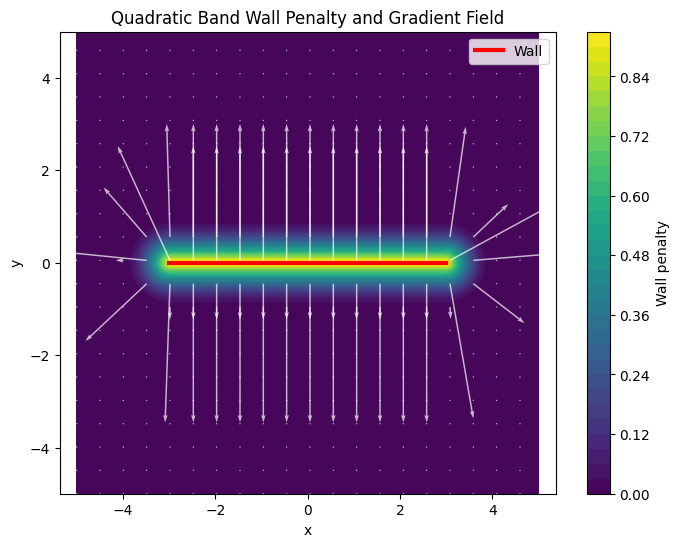

In [144]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5
N = 100

xs = np.linspace(xmin, xmax, N)
ys = np.linspace(ymin, ymax, N)
X, Y = np.meshgrid(xs, ys)

# Wall definition (horizontal wall)
a = np.array([-3.0, 0.0])
b = np.array([ 3.0, 0.0])
R = 1.0  # influence radius

# -------------------------------
# Evaluate cost field
# -------------------------------
C = np.zeros_like(X)

for i in range(N):
    for j in range(N):
        x = np.array([X[i, j], Y[i, j]])
        C[i, j] = wall_penalty(x, a, b, R)

# -------------------------------
# Numerical gradient
# -------------------------------
dCy, dCx = np.gradient(C, ys, xs)

# -------------------------------
# Plot
# -------------------------------
plt.figure(figsize=(8, 6))

# Cost contours
plt.contourf(X, Y, C, levels=30, cmap="viridis")
plt.colorbar(label="Wall penalty")

# Negative gradient (descent direction)
plt.quiver(
    X[::5, ::5], Y[::5, ::5],
    -dCx[::5, ::5], -dCy[::5, ::5],
    color="white", alpha=0.7
)

# Wall segment
plt.plot([a[0], b[0]], [a[1], b[1]], "r-", linewidth=3, label="Wall")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Quadratic Band Wall Penalty and Gradient Field")
plt.axis("equal")
plt.legend()
plt.show()

In [145]:
def plot_floor_plan(walls, start=None, goal=None, gradient=False, moves=None):
    X_MAX = 6
    Y_MAX = 6
    plt.figure(figsize=(X_MAX, Y_MAX))
    for a, b in walls:
        a = np.array(a)
        b = np.array(b)
        plt.plot([a[0], b[0]], [a[1], b[1]], "k-", linewidth=2)

    if start is not None:
        plt.plot(start[0], start[1], "go", markersize=8, label="Start")

    if goal is not None:
        plt.plot(goal[0], goal[1], "ro", markersize=8, label="Goal")

    if moves is not None:
        for index in range(len(moves)-1):
            plt.plot([moves[index][0], moves[index+1][0]], [moves[index][1], moves[index+1][1]],
                     color='purple', linestyle='dashed', linewidth=2)

    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.title("Assignment Floor Plan")
    if goal is not None and gradient:
        plt.title("Assignment Floor Plan + Gradient Field")

        steps = 0.2 #@param {type:"number"}
        x_arr_len = int((2/steps)*X_MAX + 1)
        y_arr_len = int((2/steps)*Y_MAX + 1)
        xs = np.linspace(-X_MAX, X_MAX, x_arr_len)
        ys = np.linspace(-Y_MAX, Y_MAX, y_arr_len)
        X, Y = np.meshgrid(xs, ys)
        dCx = np.zeros((x_arr_len, y_arr_len))
        dCy = np.zeros((x_arr_len, y_arr_len))
        i_cnt = 0
        j_cnt = 0
        x = -X_MAX
        y = -Y_MAX
        x_arr = []
        y_arr = []
        while x <= X_MAX: x_arr.append(x); x+= steps
        while y <= Y_MAX: y_arr.append(y); y+= steps
        for i in x_arr:
            for j in y_arr:
                dy, dx = gradient_cost([i,j], goal, walls)

                dCx[i_cnt, j_cnt] = dx
                dCy[i_cnt, j_cnt] = dy
                j_cnt += 1
            i_cnt += 1
            j_cnt = 0
        # Negative gradient (descent direction)
        plt.quiver(
            Y, X, -dCy, -dCx,
            color="Blue", alpha=0.5
        )

    plt.show()

In [146]:
# --------------------------------
# step movement
# --------------------------------
def get_movement_list(S, G, walls):
  Step_Max_Limit = 1000 #@param {type:"integer"}
  distance_per_step = 0.1 #@param {type:"number"}
  curent_postion = S
  movement_list = [curent_postion]
  step = 0
  while point_to_goal(curent_postion, G) > 0.05 and step < Step_Max_Limit:
    a, b = curent_postion
    da, db = gradient_cost(curent_postion, G, walls)
    next_position = [a - distance_per_step * da, b - distance_per_step * db ]
    movement_list.append(np.asarray(next_position))
    curent_postion = next_position
    step += 1
  return movement_list

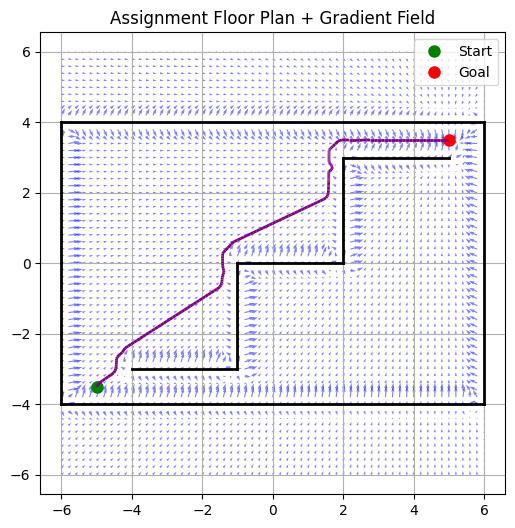

In [149]:
#@title Floor Plan Selection

floor_plan = "zigzag" #@param ["baseline", "zigzag", "deadend", "symmetric"]
use_gradient = True #@param {type:"boolean"}
create_movelist = True #@param {type:"boolean"}

walls, start, goal = load_floor_plan(floor_plan)
move_list = None
if create_movelist:
  move_list = get_movement_list(start, goal, walls)
plot_floor_plan(walls, start, goal, use_gradient, move_list)